We simulated a time series of temperature and humidity data every 15 minutes over one week.

Base pattern:

    -Temperature: 24h sinusoidal cycle (peak at noon, low at midnight)

    -Humidity: inversely correlated

    -Gaussian noise: ±1 °C (temp), ±2% (humidity)

    -30% drop every 3 days during midday (simulated cooling)

Injected anomalies:

    -Spike (step 390): +15 °C jump → point anomaly

    -Level shift (last 240 steps): +8 °C rise over 20 steps → baseline change

    -Noisy pattern (steps 20–45): alternating ±2 °C

    -High-frequency sine (steps 120–298): double-frequency temp
    
    -Multivariate anomaly (steps 290–384): humidity = temp × 1.3 + 5

In [1]:
#IMPORTAZIONI E PARAMETRI BASE
import math
import random
from datetime import datetime, timedelta
import csv
import matplotlib.pyplot as plt

# === PARAMETRI DI BASE ===
intervallo_minuti = 15
step_per_ora = 60 // intervallo_minuti # 60//15=4, somma tra interi
osservazioni_per_giorno = 24 * step_per_ora
giorni_3_mesi = 90
giorni_settimana = 7

# === RANGE TEMPERATURE/UMIDITÀ ===
T_MIN = 10
T_MAX = 25
H_MIN = 50
H_MAX = 90
ESC_T = (T_MAX - T_MIN) / 2
ESC_H = (H_MAX - H_MIN) / 2


In [2]:
#plot dati
def plot_dati(dati, titolo=""):
    x = [row[0] for row in dati]
    y_temp = [row[1] for row in dati]
    y_umid = [row[2] for row in dati]

    plt.figure(figsize=(14, 5))
    plt.plot(x, y_temp, label="Temperatura (°C)", color="red")
    plt.plot(x, y_umid, label="Umidità (%)", color="blue")
    plt.title(titolo)
    plt.xlabel("Data e Ora")
    plt.ylabel("Valore")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [3]:
# FUNZIONE PER GENERARE I DATI
def genera_dati(start_datetime, giorni, anomalie=None):
    dati = []
    totale_step = giorni * osservazioni_per_giorno

    for i in range(totale_step):
        timestamp = start_datetime + timedelta(minutes=i * intervallo_minuti)
        ora_decimale = timestamp.hour + timestamp.minute / 60
        #Converte l’ora del timestamp in un valore decimale, utile per funzioni sinusoidali (es. 14:30 -> 14.5).

        #la sinusoide fatta in maniera che parta dal minimo (mezzanotte = minimo)
        sin_temp = math.sin(2 * math.pi * (ora_decimale-6) / 24)
        sin_umid = -sin_temp  # andamento opposto

        # Rumore casuale di tipo gaussiano --> variazioni naturali
        rumore_temp = random.gauss(0, 1)
        rumore_umid = random.gauss(0, 2)

        # Calcola il valore finale per quell'osservazione
        temperatura = T_MIN + ESC_T * (1 + sin_temp) + rumore_temp
        umidita = H_MIN + ESC_H * (1 + sin_umid) + rumore_umid

        giorno_corrente = i // osservazioni_per_giorno

        def applica_smorz(valore, posizione_nel_giorno, fattore_smorz):
            if posizione_nel_giorno<48:
                intensita_smorz = posizione_nel_giorno/48
            else:
                intensita_smorz = 2 - (posizione_nel_giorno/48)
            valore = valore * (1-(intensita_smorz*fattore_smorz)) #valore fattore intensita_smorz     #((0.9*(intensita_smorz)))
            return valore

        # Ogni 3 giorni riduce i picchi del 30%
        if giorno_corrente % 3 == 0:
            temperatura = applica_smorz(temperatura, i%96, 0.3)
            umidita = applica_smorz(umidita, i%96, -0.3)

        dati.append([timestamp, temperatura, umidita])

    if anomalie:
        for funzione_anomalia in anomalie:
            funzione_anomalia(dati)

    return dati


In [15]:
# === FUNZIONI PER INSERIRE LE ANOMALIE

def anomalia_spike(dati):
    #Aggiunge un picco improvviso a metà del dataset
    #i = len(dati) // 2
    i=390
    dati[i][1] += 15  # aumento anomalo della temperatura

#def anomalia_step(dati):
#    #Aumenta bruscamente i valori di temperatura in un intervallo <--> cambio di livello
#    start = len(dati)-200
#    end = len(dati)
#    for i in range(start, end):
#        if i < len(dati):
#            dati[i][1] += 8

def anomalia_step(dati):
    #Aumenta bruscamente i valori di temperatura in un intervallo <--> cambio di livello
    lunghezza_rampa = 20
    start = len(dati)-240
    end = len(dati)
    posizione_in_rampa=0
    for i in range(start, end):
        if i < start + lunghezza_rampa:
            posizione_in_rampa +=1
            fattore_rampa =  posizione_in_rampa  / lunghezza_rampa
        else:
            fattore_rampa = 1
        if i < len(dati):
            dati[i][1] += 8 *fattore_rampa

def anomalia_rumore_anomalo(dati):
    #Aggiunge un pattern ciclico di rumore a bassa frequenza
    pattern = [2, -2]
    start = 20
    end = 45
    for idx, i in enumerate(range(start, end)):
        if i < len(dati):
            dati[i][1] += pattern[idx % len(pattern)]

#def anomalia_contestuale(dati):
    #Inserisce un valore fuori scala in un contesto altrimenti normale
 #   if 30 < len(dati):
  #      dati[30][1] = 25

def anomalia_pattern(dati):
    #Sovrascrive un intervallo con un'onda sinusoidale e rumore --> cambia il periodo della sinuoide
    import math, random
    #start = 500
    #end = 670

    start = 120
    end = (96*3)+10
    
    lunghezza = end - start
    for idx, i in enumerate(range(start, end)):
        if i < len(dati):
            wave = (4 * math.sin((math.pi * idx / (lunghezza - 1))*2))
            rumore = random.gauss(0, 1)
            dati[i][1] = 14 + wave + rumore

def anomalia_multivariata(dati):
    #Sovrascrive un intervallo con un'onda sinusoidale e rumore --> cambia il periodo della sinuoide
    for i in range(len(dati)):
        # [datetime.datetime(2025, 6, 8, 0, 0), 10.0, 90.0]
        if i > (96*3)  and i< (96*4):
            dati[i][1] = dati[i-96][1]  


In [16]:
#SALVATAGGIO DATI IN FILE CSV
#viene definita una funzione che mi permette di salvare i dati in un file csv.
def salva_blocco_csv(dati, nome_file):
    with open(nome_file, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["Timestamp", "Temperatura (°C)", "Umidità (%)"])
        for riga in dati:
            writer.writerow(riga)


In [17]:
#GENERAZIONE DATASET COMPLETI
base_datetime = datetime(2025, 6, 1)

# 1. Tre mesi normali
dati_3_mesi = genera_dati(base_datetime, giorni_3_mesi)
salva_blocco_csv(dati_3_mesi, "dati_3_mesi.csv")
#plot_dati(dati_3_mesi)




anomalia_spike


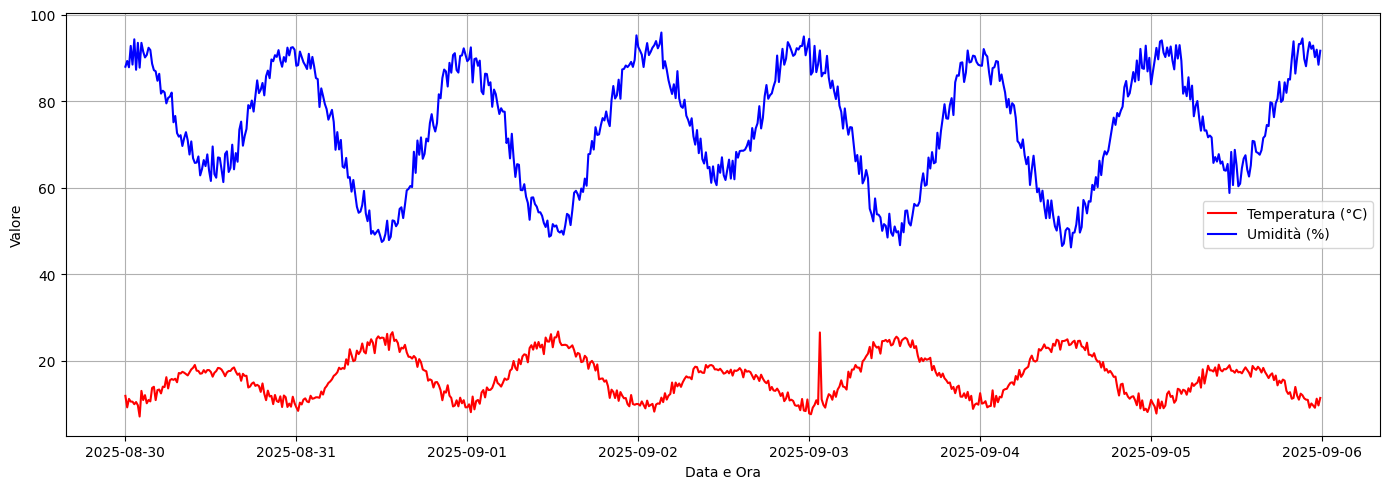



anomalia_step


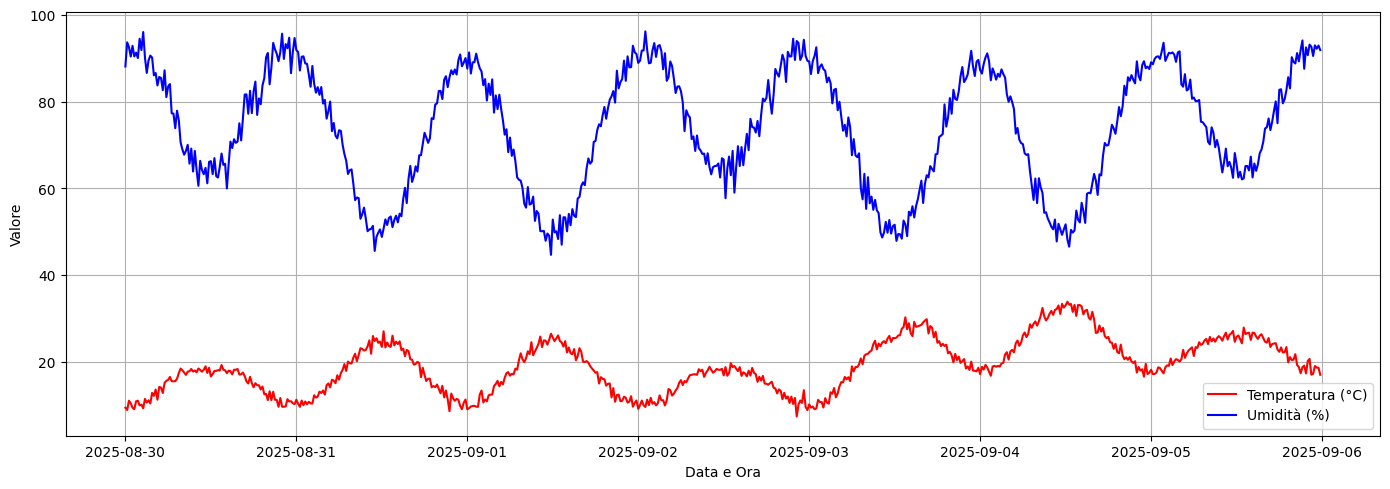



anomalia_rumore_anomalo


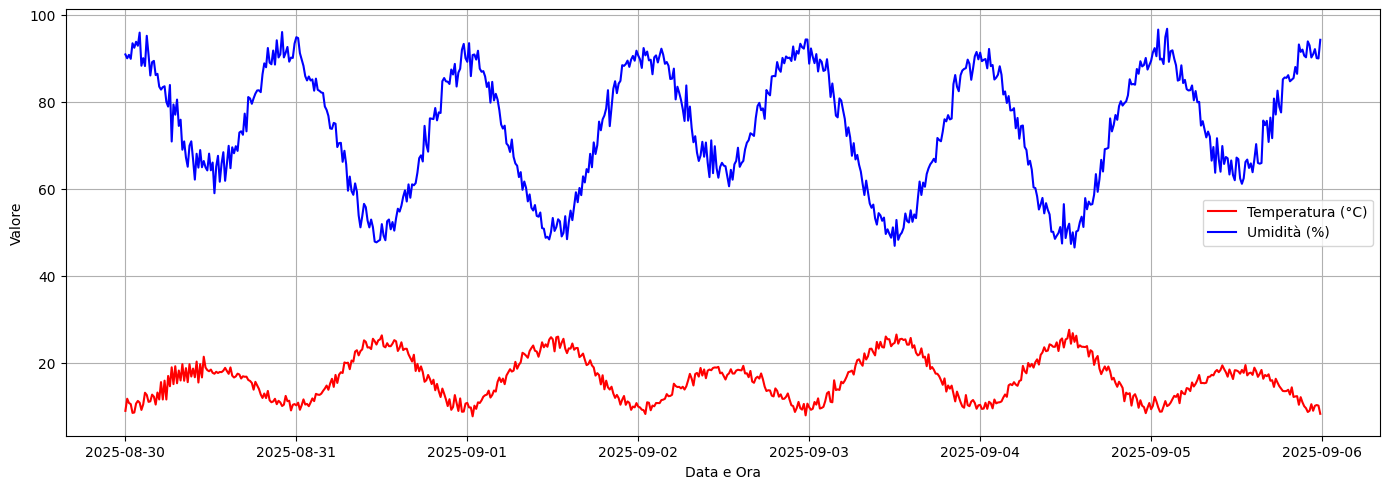



anomalia_multivariata


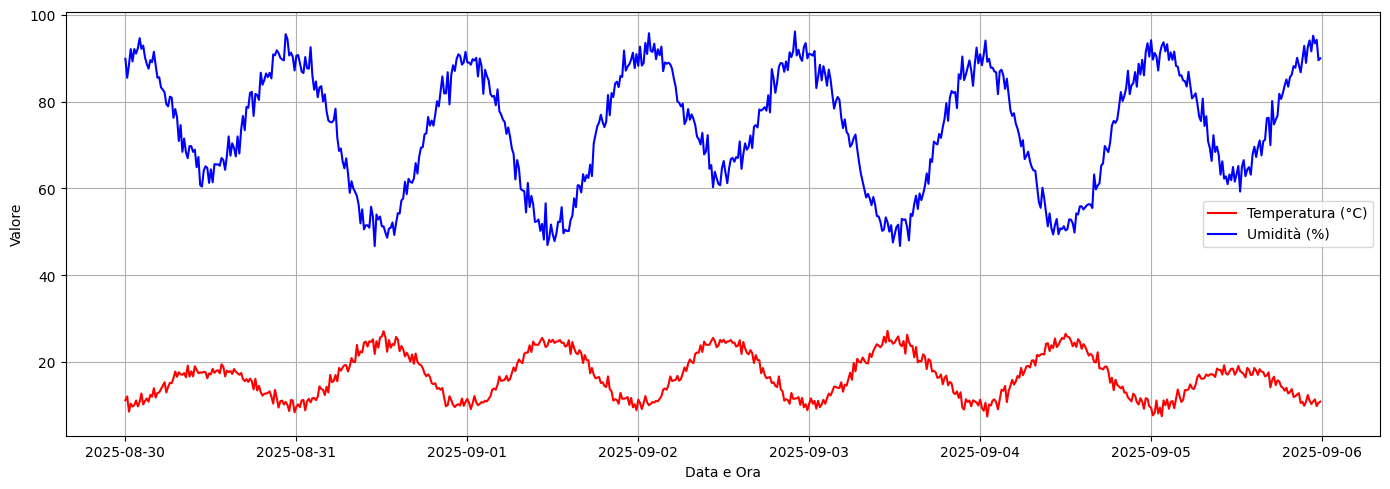



anomalia_pattern


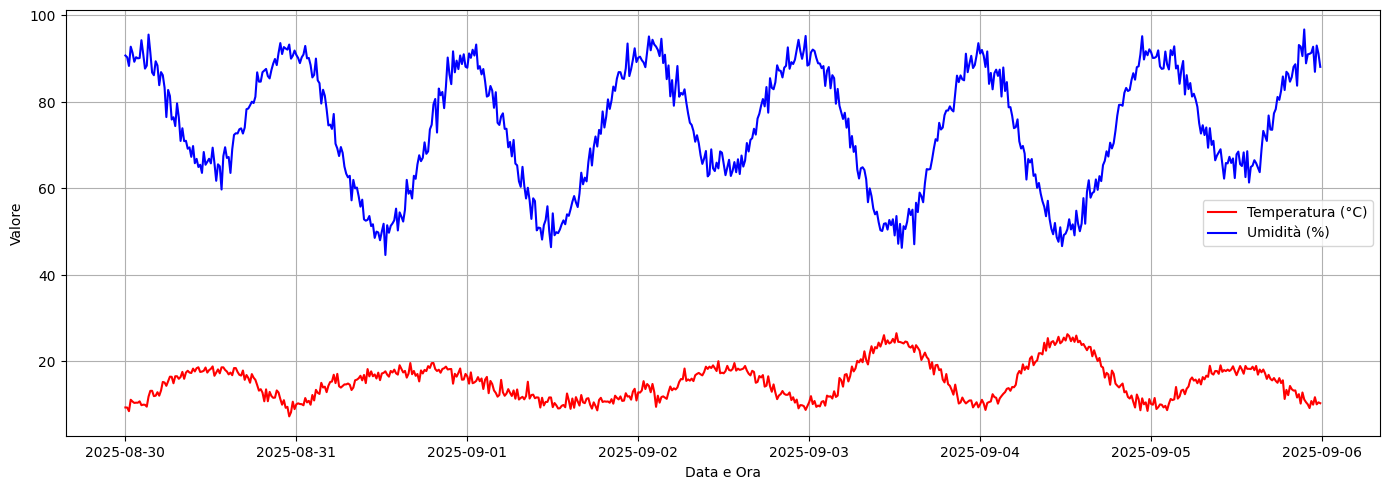

In [18]:
# 2. Settimane con una singola anomalia
#lista di funzioni, ognuna rappresenta un tipo diverso di anomalia da applicare ai dati.
anomalie_funz = [
    anomalia_spike,
    anomalia_step,
    anomalia_rumore_anomalo,
    anomalia_multivariata,
    anomalia_pattern,
]

blocchi_anomalie = []
for i, anomalia in enumerate(anomalie_funz):
    #start_dt = base_datetime + timedelta(days=giorni_3_mesi + i * giorni_settimana)
    start_dt = base_datetime + timedelta(days=giorni_3_mesi)
    dati_blocco = genera_dati(start_dt, giorni_settimana, anomalie=[anomalia])
    blocchi_anomalie.append(dati_blocco)
    print('\n\n'+str(anomalia).split(' ')[1])
    plot_dati(dati_blocco)
    salva_blocco_csv(dati_blocco, f"{anomalia.__name__}.csv")

# 3. Settimana normale + settimana con tutte le anomalie
start_norm = base_datetime + timedelta(days=giorni_3_mesi + len(anomalie_funz) * giorni_settimana)
dati_settimana_normale = genera_dati(start_norm, giorni_settimana)
salva_blocco_csv(dati_settimana_normale, "settimana_normale.csv")

start_anom = start_norm + timedelta(days=giorni_settimana)
dati_settimana_con_tutto = genera_dati(start_anom, giorni_settimana, anomalie=anomalie_funz)
salva_blocco_csv(dati_settimana_con_tutto, "settimana_con_tutte_le_anomalie.csv")


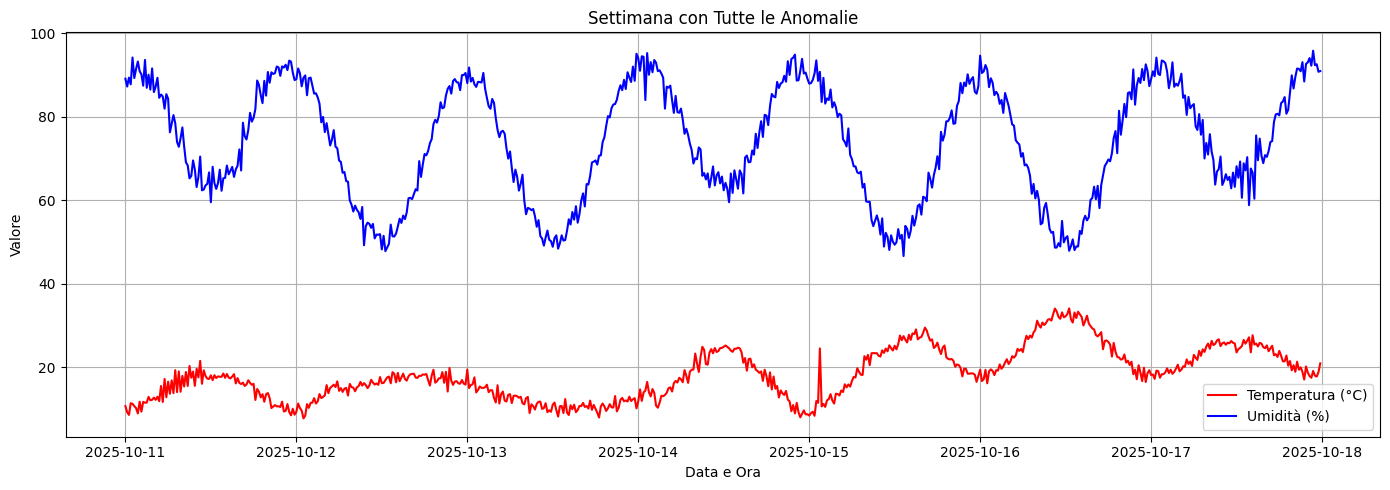

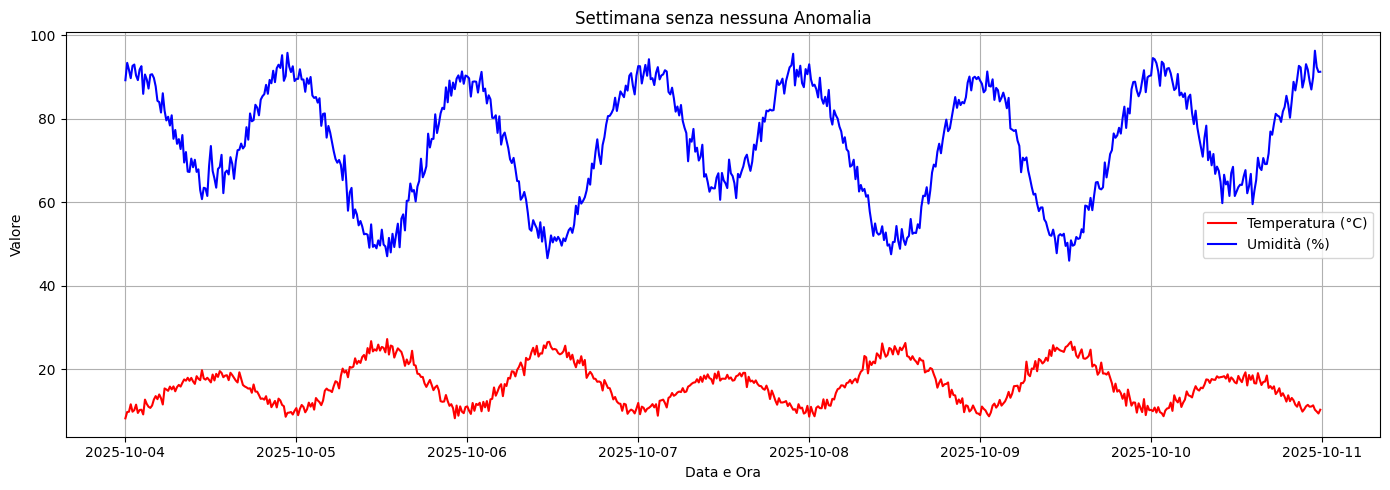

In [19]:
#VISUALIZZAZIONE DEL GRAFICO DI UNA SETTIMANA


# Esempio: plot della settimana con tutte le anomalie
plot_dati(dati_settimana_con_tutto, titolo="Settimana con Tutte le Anomalie")

plot_dati(dati_settimana_normale, titolo="Settimana senza nessuna Anomalia")
